# https://micropore.wordpress.com/2011/12/05/pymc-bayesian-fit-fpr-python/


In [1]:
!date
%matplotlib inline

Mon Aug 29 14:29:07 MDT 2016


In [2]:
import pymc
import numpy as np
import spacepy.plot as spp # for the style
import matplotlib.pyplot as plt
import spacepy.toolbox as tb

This unreleased version of SpacePy is not supported by the SpacePy team.


/Users/balarsen/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


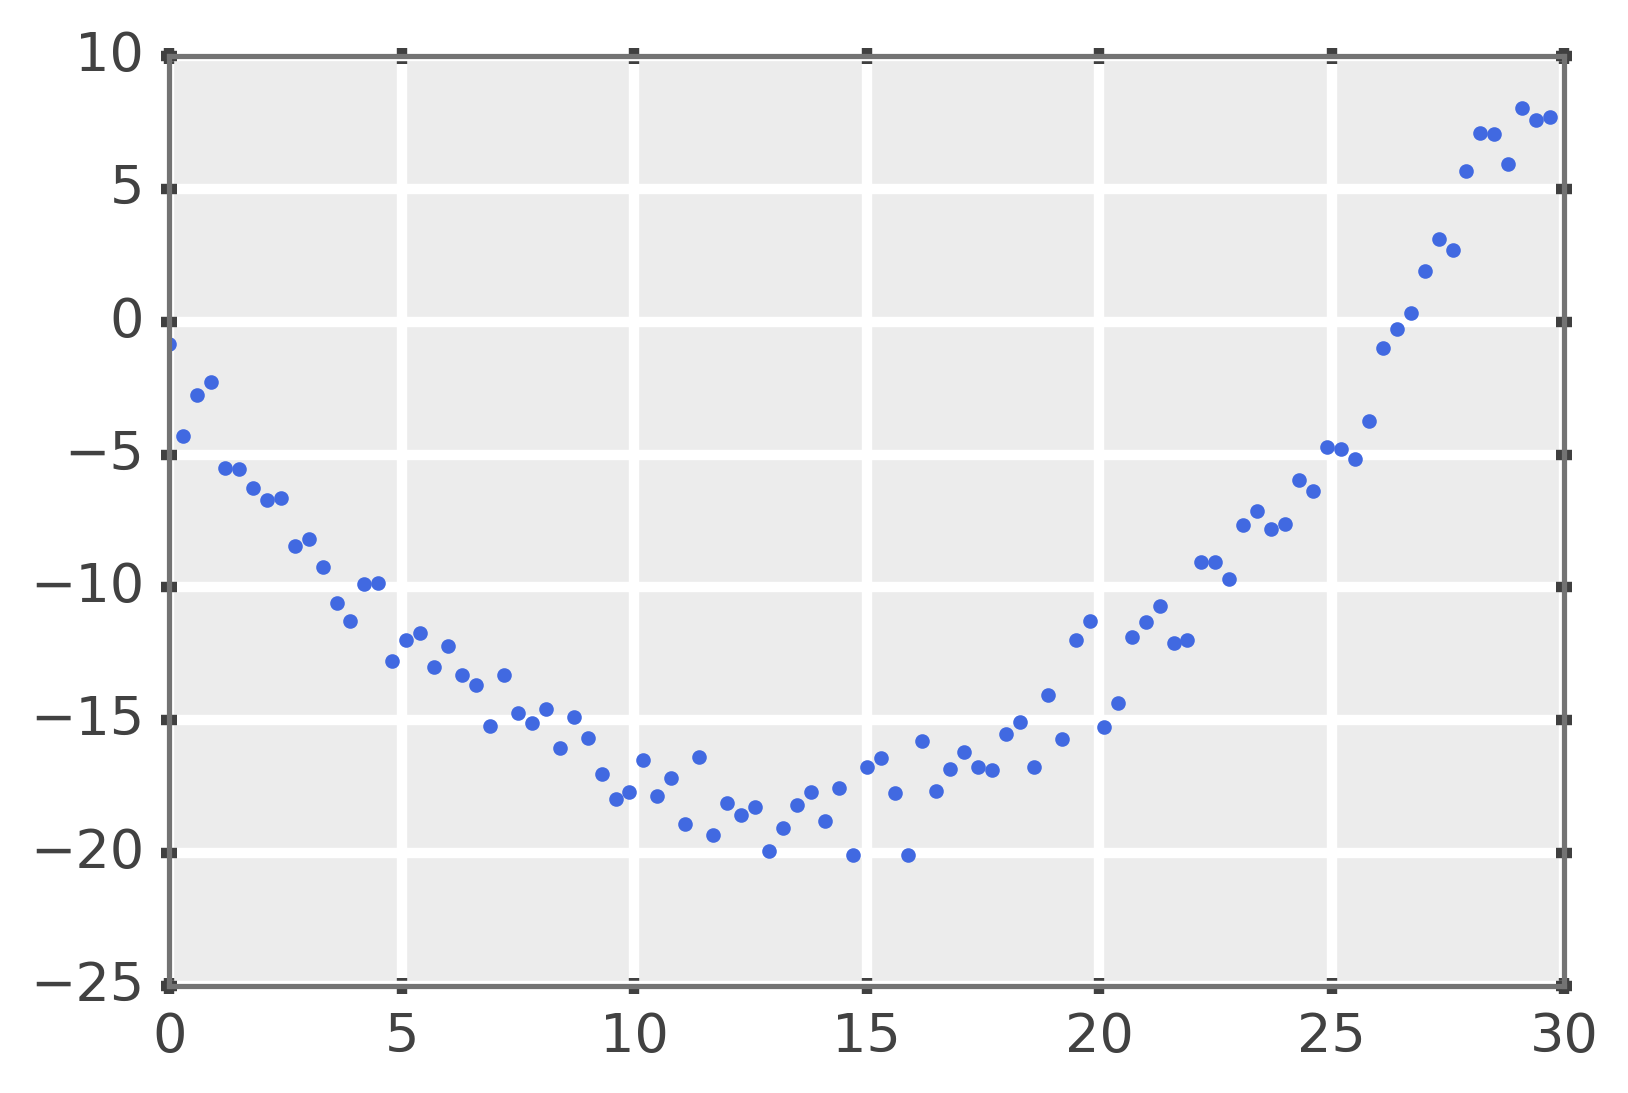

In [3]:
# create some test data
x = np.arange(100) * 0.3
f = 0.1 * x**2 - 2.6 * x - 1.5
np.random.seed(76523654)
noise = np.random.normal(size=100) * 1.     # create some Gaussian noise
f = f + noise                                # add noise to the data
plt.plot(x, f, '.')

In [4]:
# the traditional chi-square fit
z = np.polyfit(x, f, 2)   
print('The chi-square result: ',  z)


The chi-square result:  [ 0.09924399 -2.58796431 -1.42786014]


In [8]:

#priors
sig = pymc.Uniform('sig', 0.0, 100.0, value=1.)

a = pymc.Uniform('a', -10.0, 10.0, value= 0.0)
b = pymc.Uniform('b', -10.0, 10.0, value= 0.0)
c = pymc.Uniform('c', -10.0, 10.0, value= 0.0)

In [9]:

#model
@pymc.deterministic(plot=False)
def mod_quadratic(x=x, a=a, b=b, c=c):
      return a*x**2 + b*x + c

In [10]:

#likelihood
y = pymc.Normal('y', mu=mod_quadratic, tau=1.0/sig**2, value=f, observed=True)
#———————————————————–


 [------------------------139%------------------------] 75208 of 54000 complete in 14.5 secCould not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.
Plotting sig
Plotting a
Plotting c
Plotting b

sig:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.114            0.082            0.001            [ 0.955  1.27 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.967            1.057           1.11           1.163         1.29
	

a:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.1              0.001            0.0              [ 0.097  0.103]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===

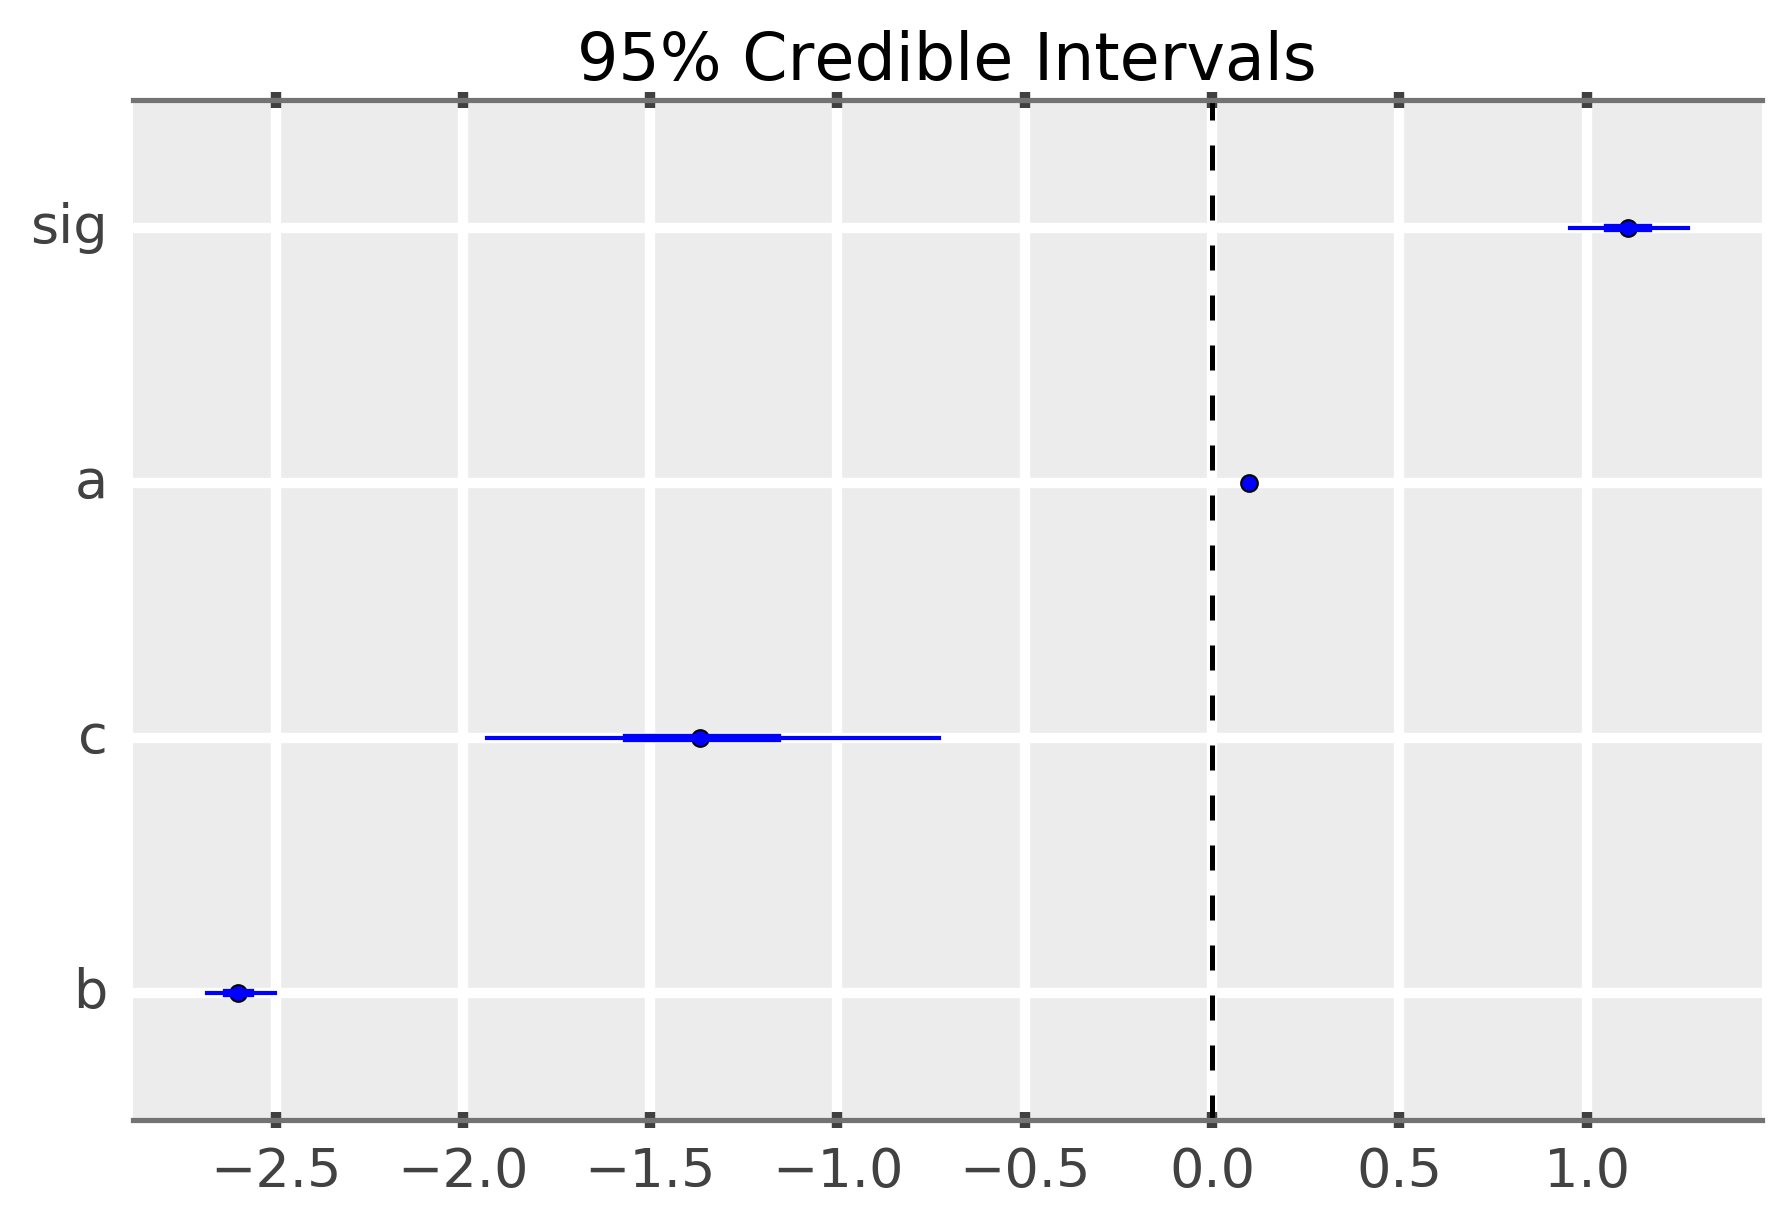

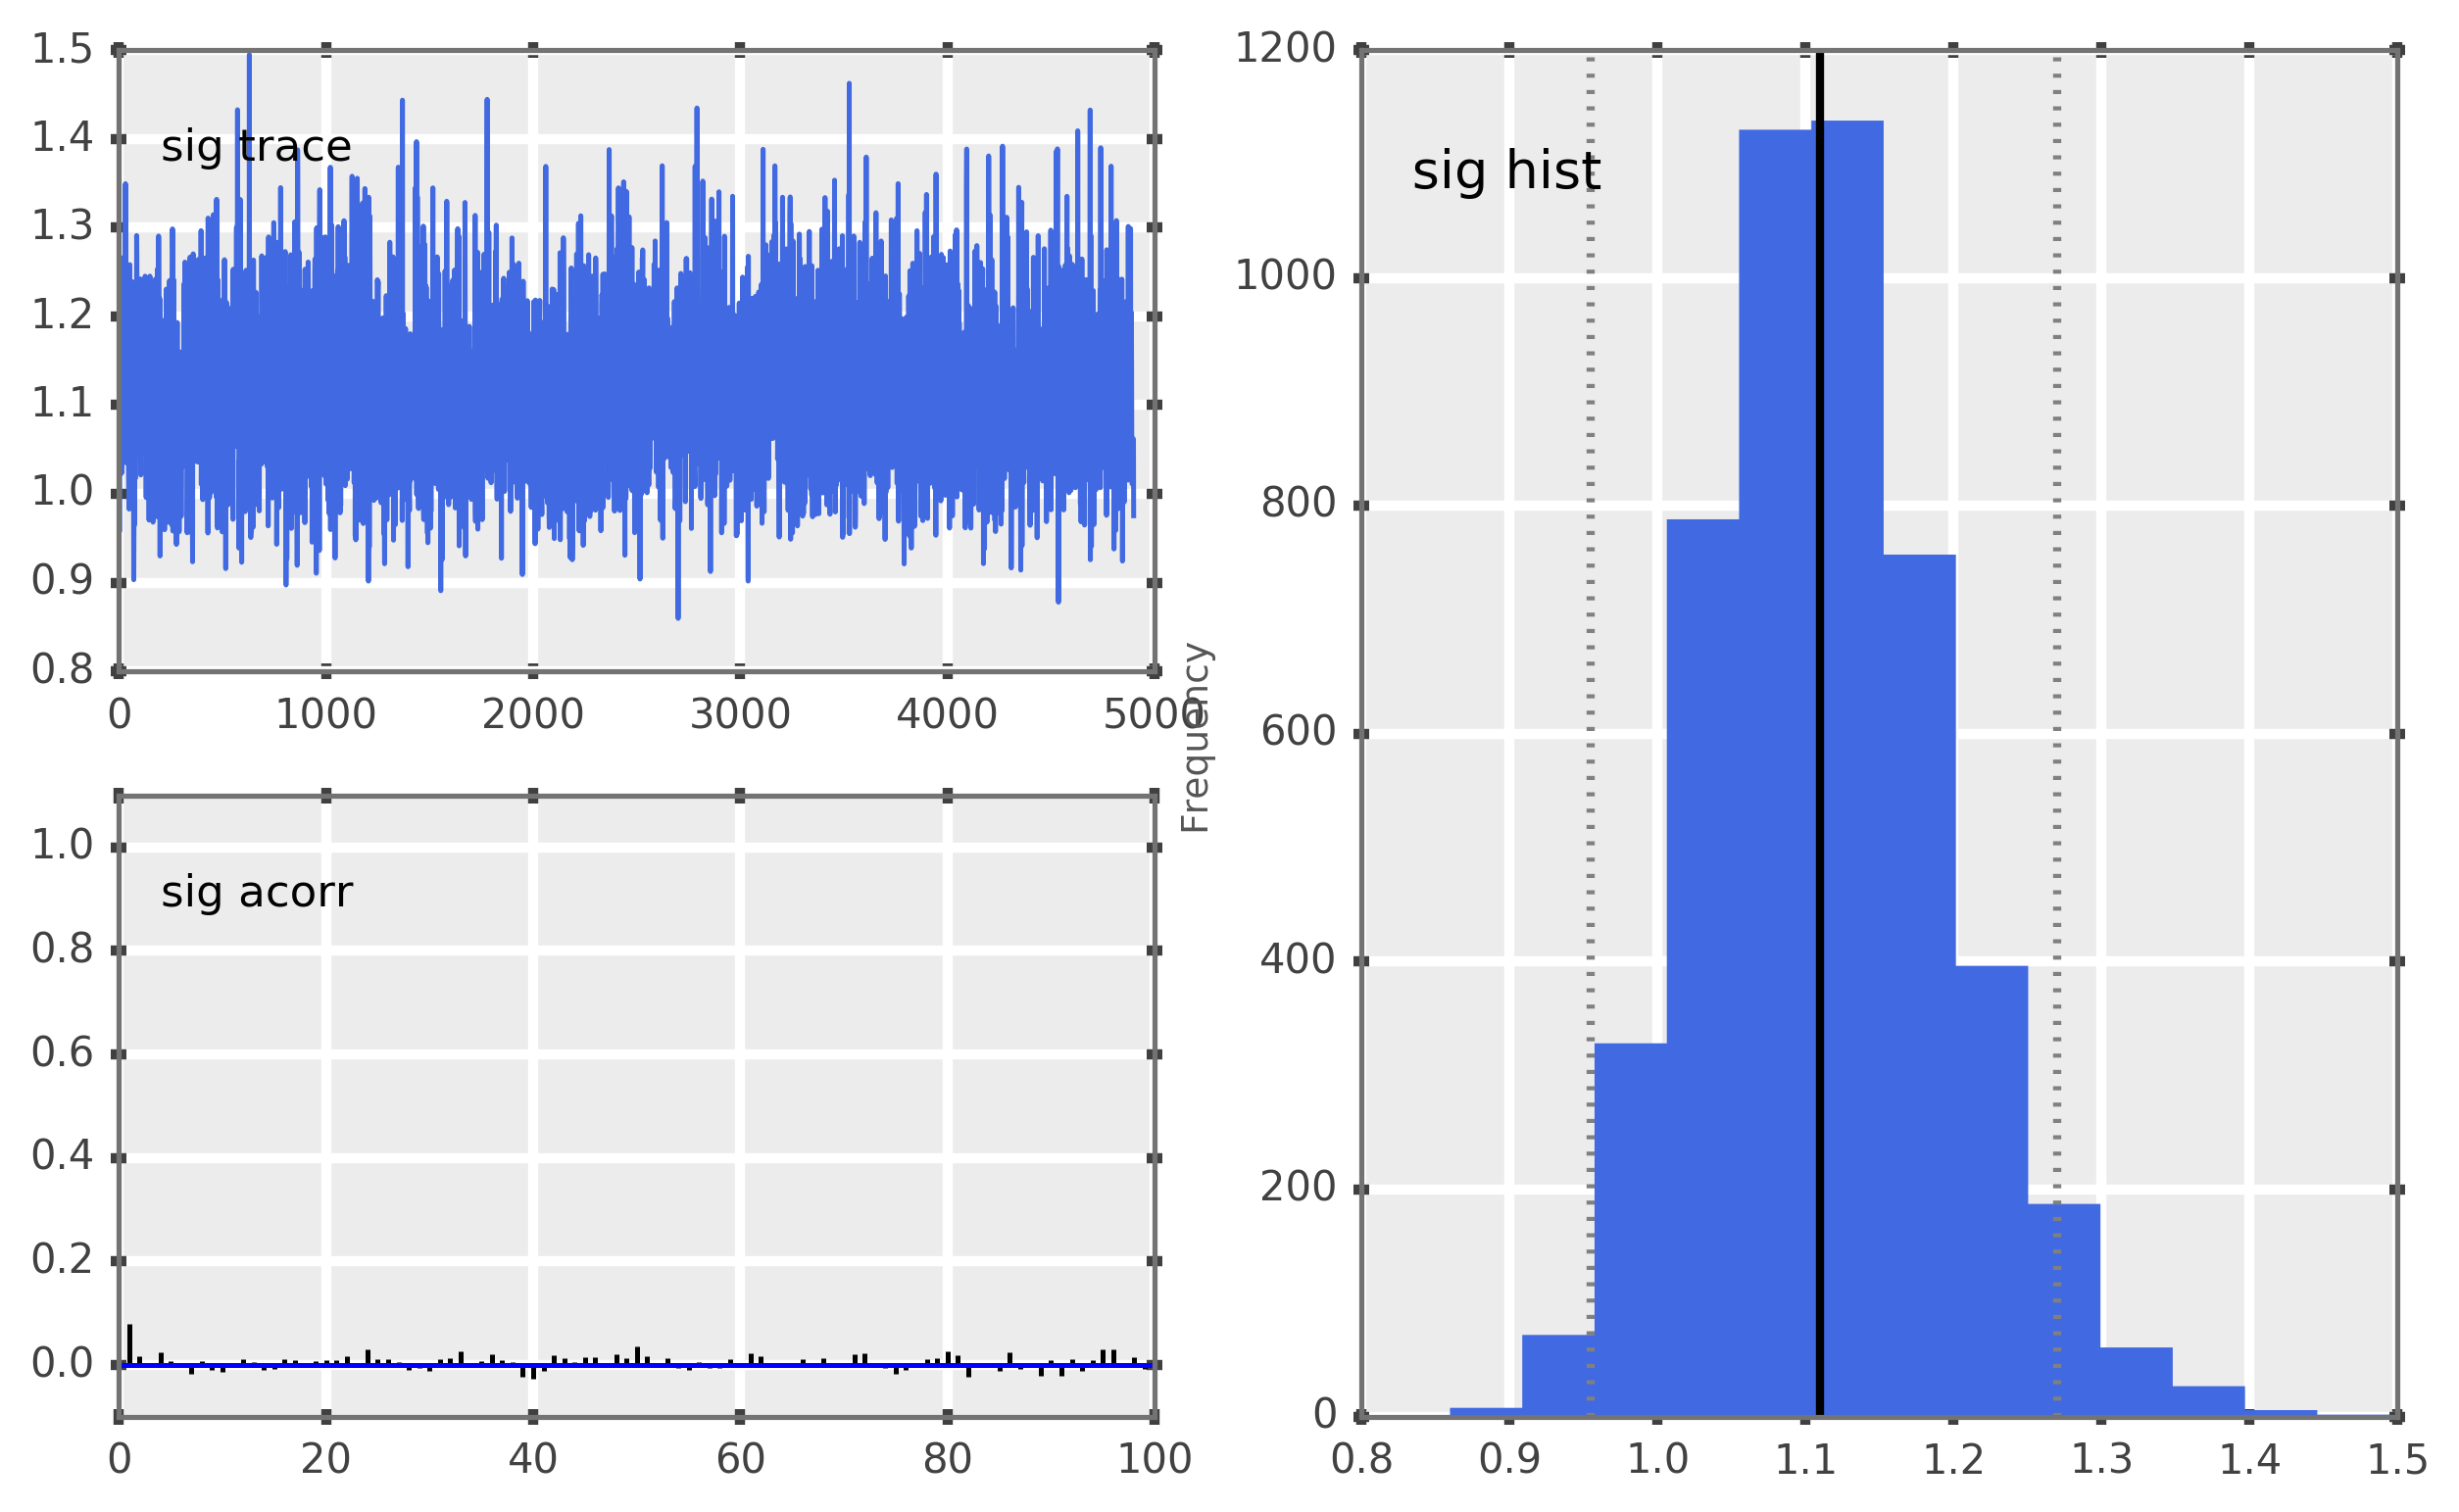

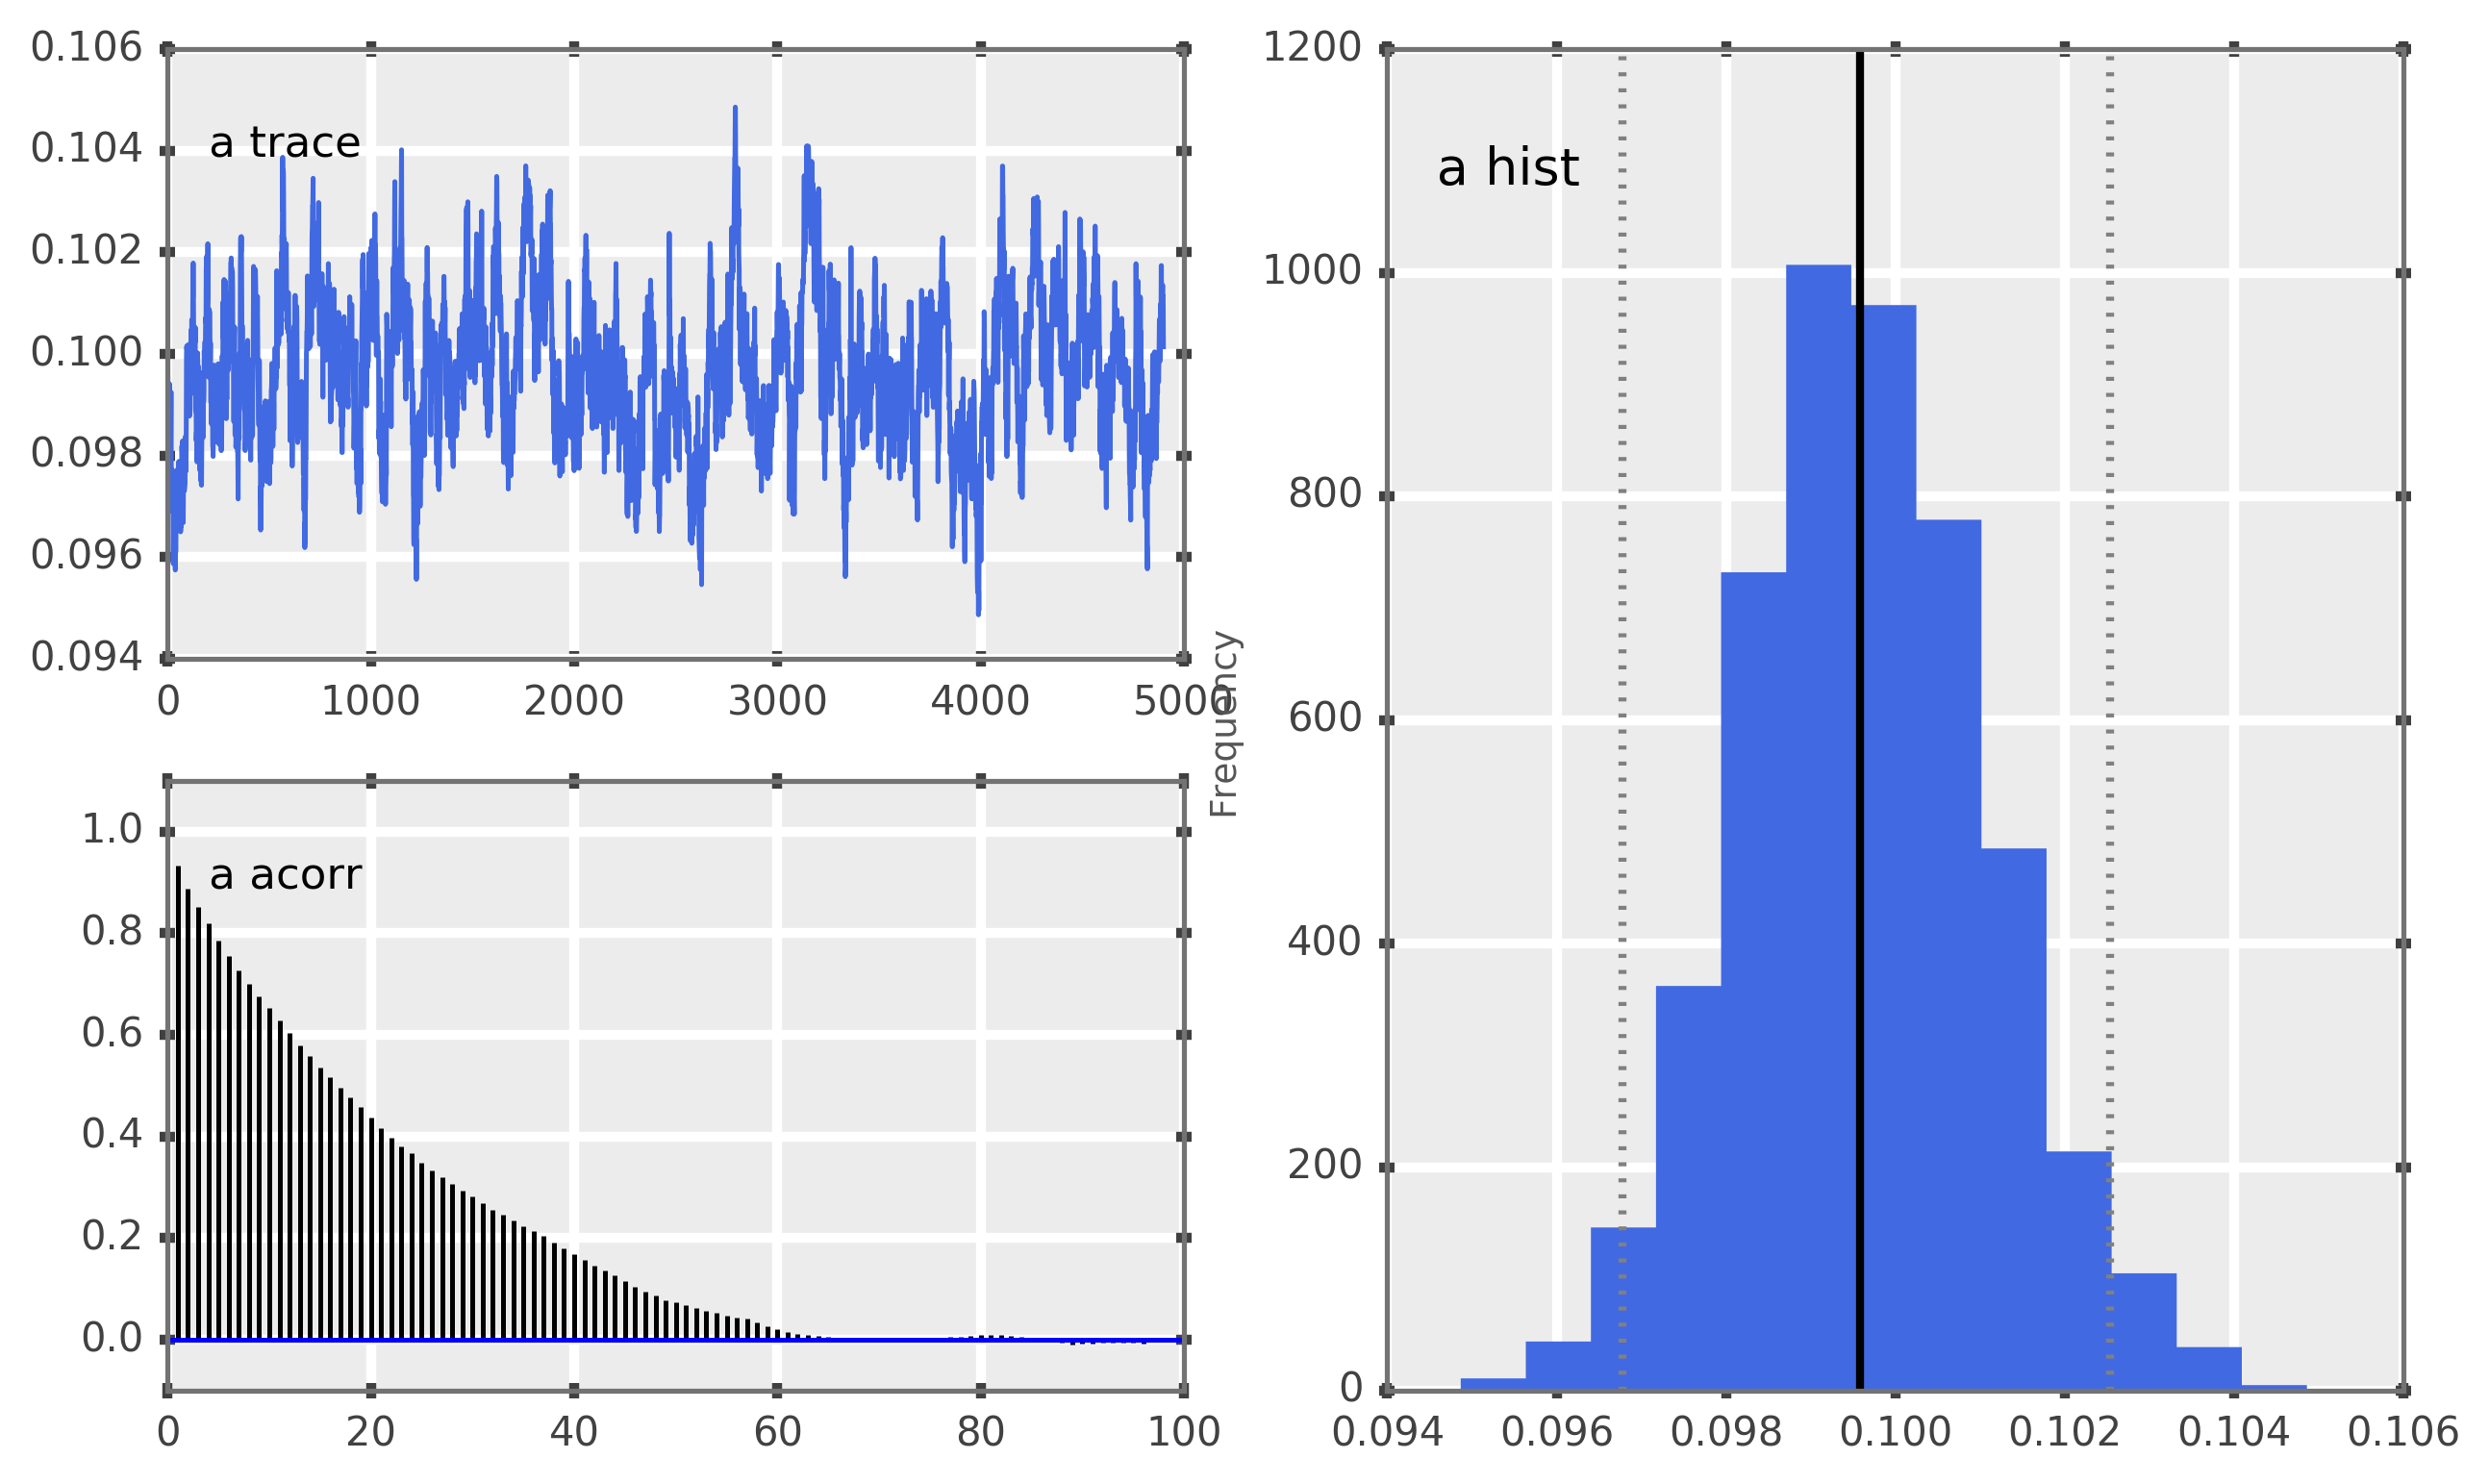

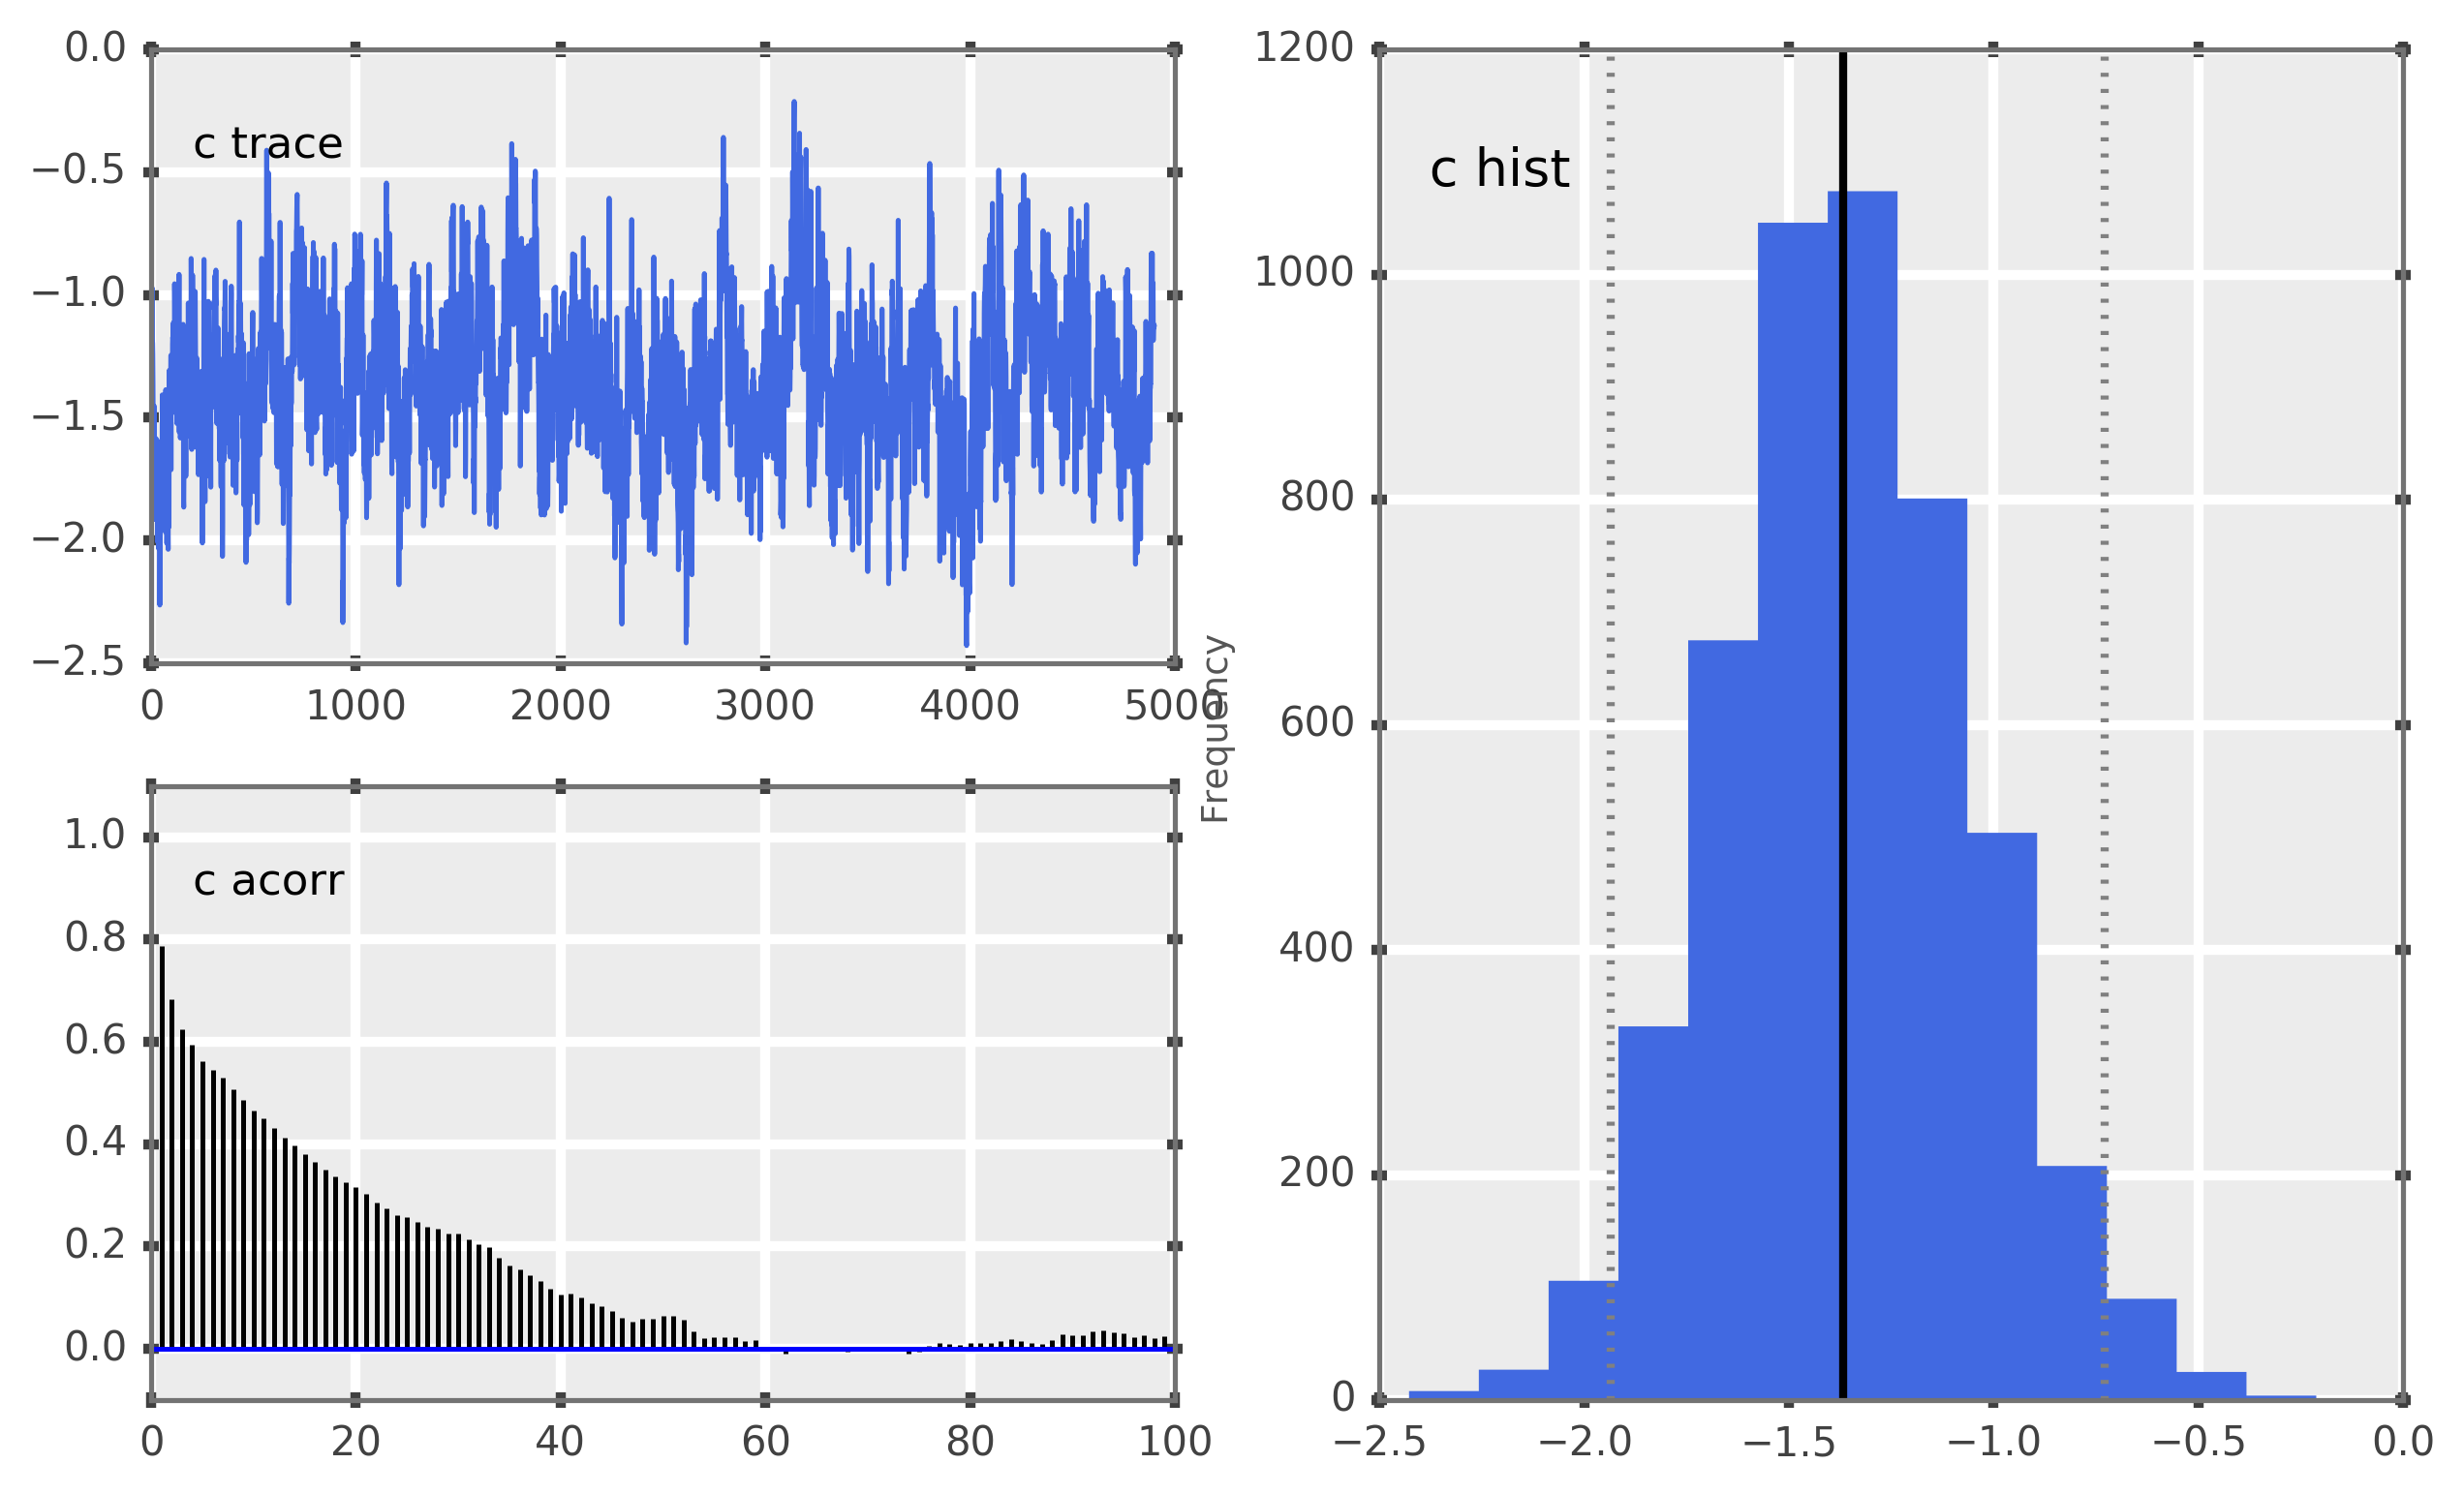

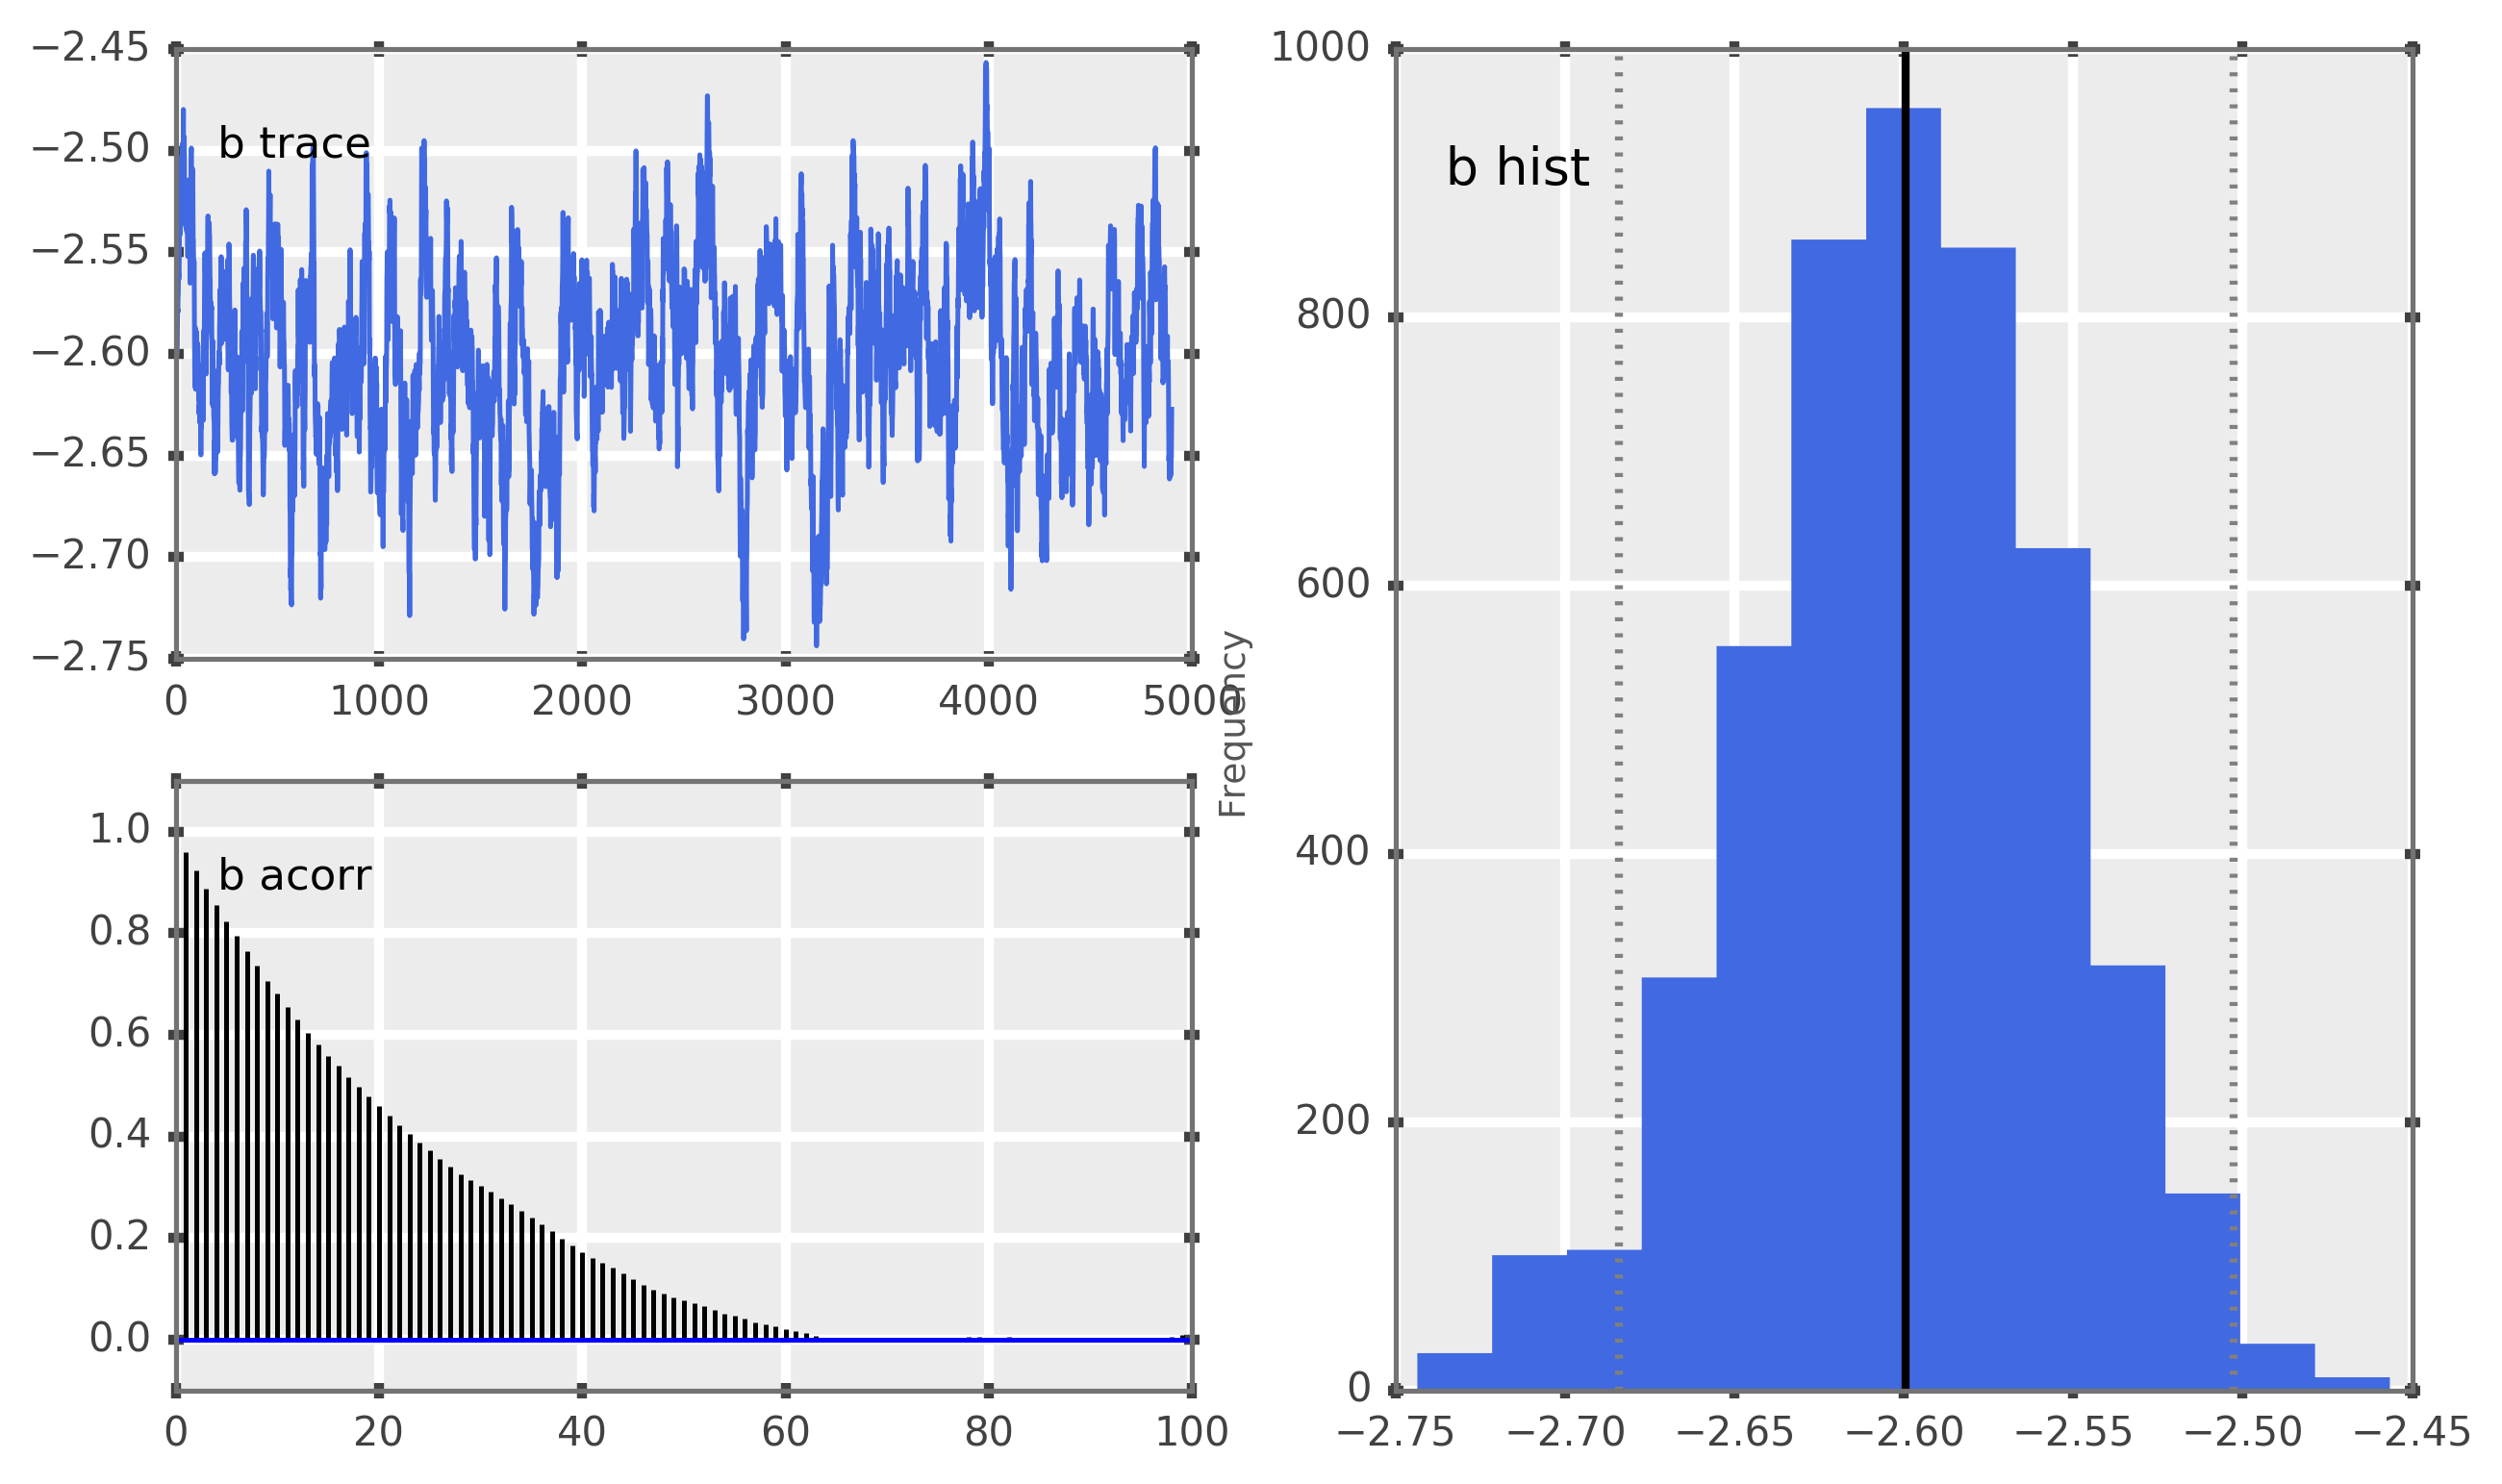

In [12]:

# Now, go to command line and run the following (or alternatively put them in a file):

R = pymc.MCMC((sig, a, b, c, y))    #  build the model
R.sample(50000, 1000, thin=10, burn_till_tuned=True)              # populate and run it
R.stats()
pymc.Matplot.summary_plot(R)
pymc.Matplot.plot(R)
R.summary()


In [23]:
R.stats()['a']['mean']

0.099644893784361019

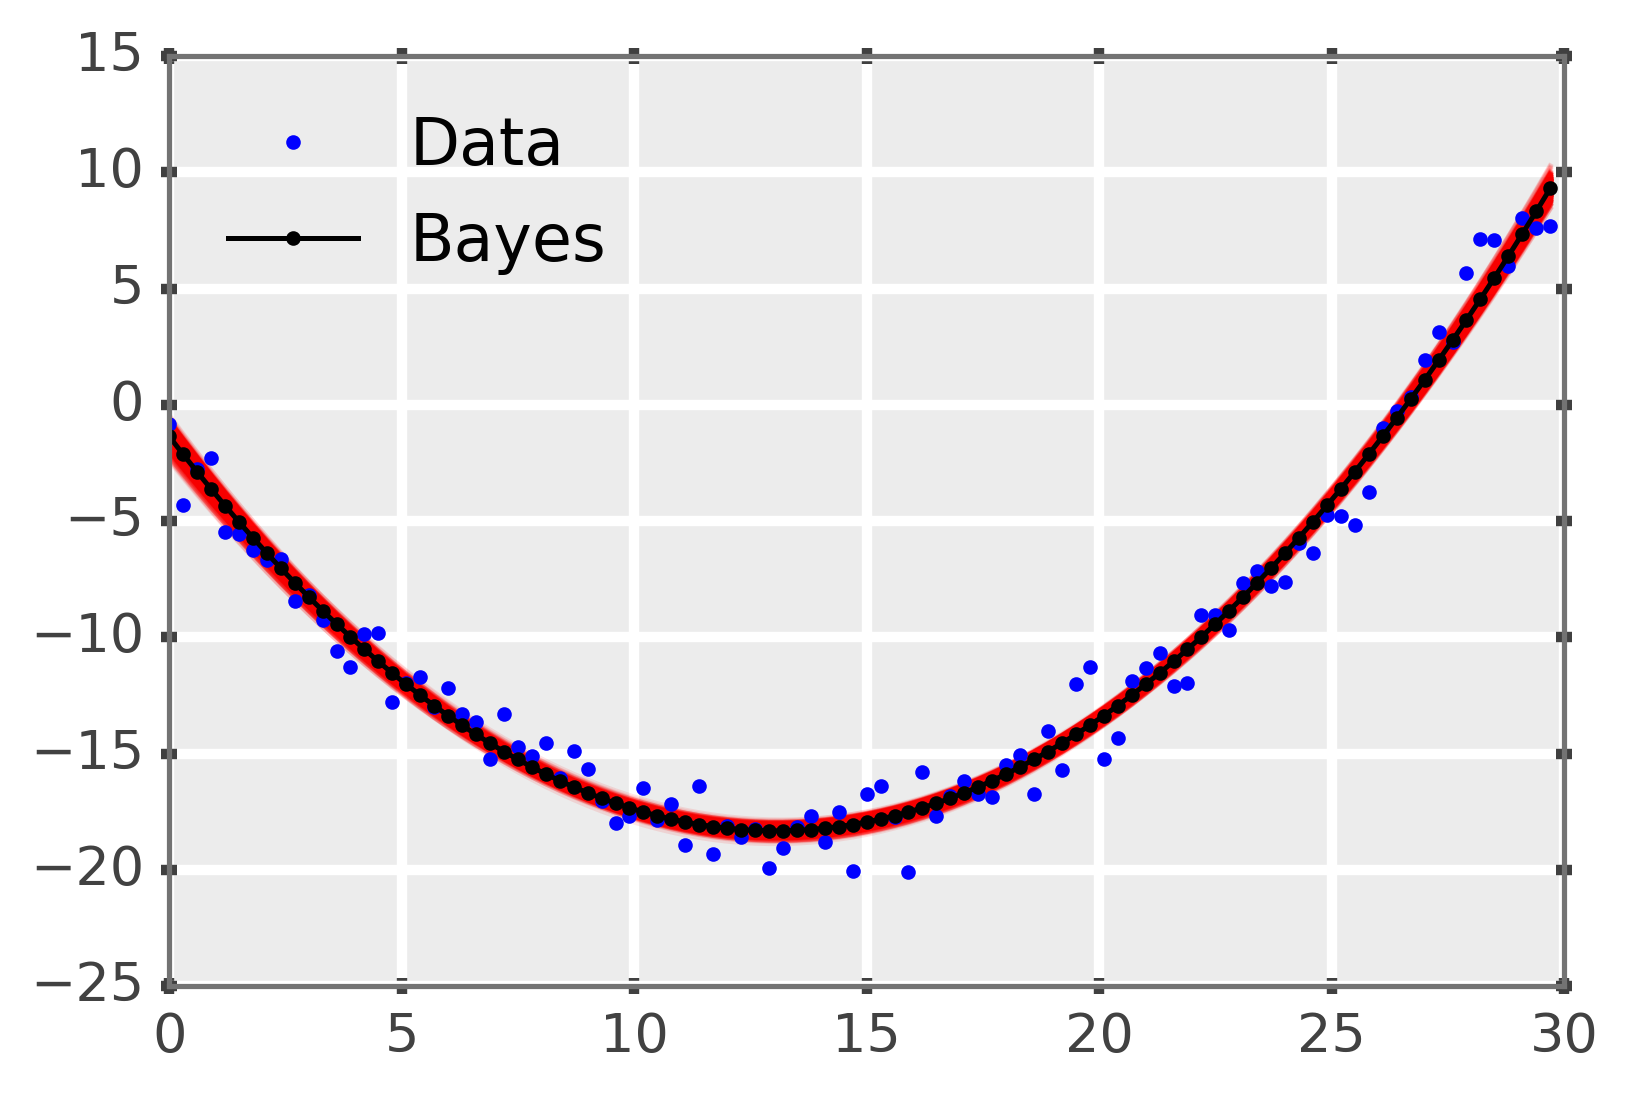

In [31]:



ind = np.random.random_integers(len(R.trace('a')[...])-1, size=1000)
vals = np.zeros([len(x), len(ind)], dtype=float)
for ii, trace in enumerate(ind):
    vals[:,ii] = R.trace('a')[...][trace]*x**2 + R.trace('b')[...][trace]*x + R.trace('c')[...][trace]
    plt.plot(x, vals[:,ii], c='r', alpha=0.1)

plt.plot(x, f, '.', label='Data', c='b')
# plt.plot(x,z[0]*x**2 + z[1]*x + z[2], label='Chi sq', c='g')
plt.plot(x, R.stats()['a']['mean']*x**2 + 
         R.stats()['b']['mean']*x + 
         R.stats()['c']['mean'], 'k.-', label='Bayes')
plt.legend(loc='upper left')

In [13]:
# get the median absolute deviation of the residuals for each method
res1 = np.abs(f-z[0]*x**2 + z[1]*x + z[2])
mad1 = tb.medAbsDev(res1)
res2 = np.abs(f-R.a.value*x**2 + 
         R.b.value*x + 
         R.c.value)
mad2 = tb.medAbsDev(res2)
print('Chi sq MedAbsDev: {0}'.format(mad1))
print('Bayes MedAbsDev: {0}'.format(mad2))



Chi sq MedAbsDev: 38.9096114141553
Bayes MedAbsDev: 39.39383756738502


In [14]:
print(z, (R.a.value, R.b.value, R.c.value))

[ 0.09924399 -2.58796431 -1.42786014] (array(0.10003927604176499), array(-2.6286693551496256), array(-0.9340966981763573))
